In [120]:
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from tqdm import tqdm

# Load the FITS file
with fits.open("/Users/calvinsridhara/Documents/GitHub/M33_Analysis/Tables/m33_vels_stars_inc22B_donedupes.fits") as hdul:
    data = hdul[1].data
    df = pd.DataFrame(data.astype(data.dtype.newbyteorder('=')))

# Remove foreground stars
print(f"Total stars before Foreground removal: {len(df)}")
df = df[df['FG_SEL'] != 1].copy()
print(f"Total stars after Foreground removal: {len(df)}")

Total stars before Foreground removal: 5775
Total stars after Foreground removal: 5256


In [121]:
from collections import Counter

# Define the SEL flags to check
sel_flags = ['RGB_SEL', 'AGB_SEL', 'CBN_SEL', 'YMS_SEL', 'WCN_SEL', 'RHB_SEL', 'OHB_SEL' , 'FG_SEL']

def get_active_flags(row):
    return tuple(sorted([flag for flag in sel_flags if row[flag] == 1]))


df['sel_combo'] = df.apply(get_active_flags, axis=1)

# Count frequency of each unique flag combination
combo_counts = Counter(df['sel_combo'])

# Display results
print("Number of stars for each SEL flag combination:")
for combo, count in combo_counts.items():
    label = ', '.join(combo) if combo else 'None'
    print(f"{label}: {count}")

Number of stars for each SEL flag combination:
RGB_SEL: 2361
AGB_SEL: 642
OHB_SEL: 475
RHB_SEL: 636
YMS_SEL: 308
OHB_SEL, WCN_SEL: 44
AGB_SEL, CBN_SEL: 144
RHB_SEL, WCN_SEL: 475
CBN_SEL, RHB_SEL: 10
RGB_SEL, WCN_SEL: 57
AGB_SEL, WCN_SEL: 58
CBN_SEL, RGB_SEL: 21
WCN_SEL, YMS_SEL: 4
None: 20
WCN_SEL: 1


In [122]:
# Initialize age group column
df['age_group'] = 'unclassified'

# Define age selection flags
young_flags = ['YMS_SEL', 'OHB_SEL', 'WCN_SEL']
int_flags   = ['AGB_SEL', 'RHB_SEL', 'CBN_SEL']
old_flags   = ['RGB_SEL']

# Count number of flags active per age group
df['young_count'] = df[young_flags].sum(axis=1)
df['int_count']   = df[int_flags].sum(axis=1)
df['old_count']   = df[old_flags].sum(axis=1)

# Total number of distinct age groups turned on
df['group_sum'] = ((df['young_count'] > 0).astype(int) + 
                   (df['int_count'] > 0).astype(int) + 
                   (df['old_count'] > 0).astype(int))

# Assign age group only if the star falls into one and only one group
df.loc[(df['group_sum'] == 1) & (df['old_count'] > 0), 'age_group'] = 'old'
df.loc[(df['group_sum'] == 1) & (df['int_count'] > 0), 'age_group'] = 'int'
df.loc[(df['group_sum'] == 1) & (df['young_count'] > 0), 'age_group'] = 'young'

# Display count
print(df['age_group'].value_counts())

age_group
old             2361
int             1432
young            832
unclassified     631
Name: count, dtype: int64


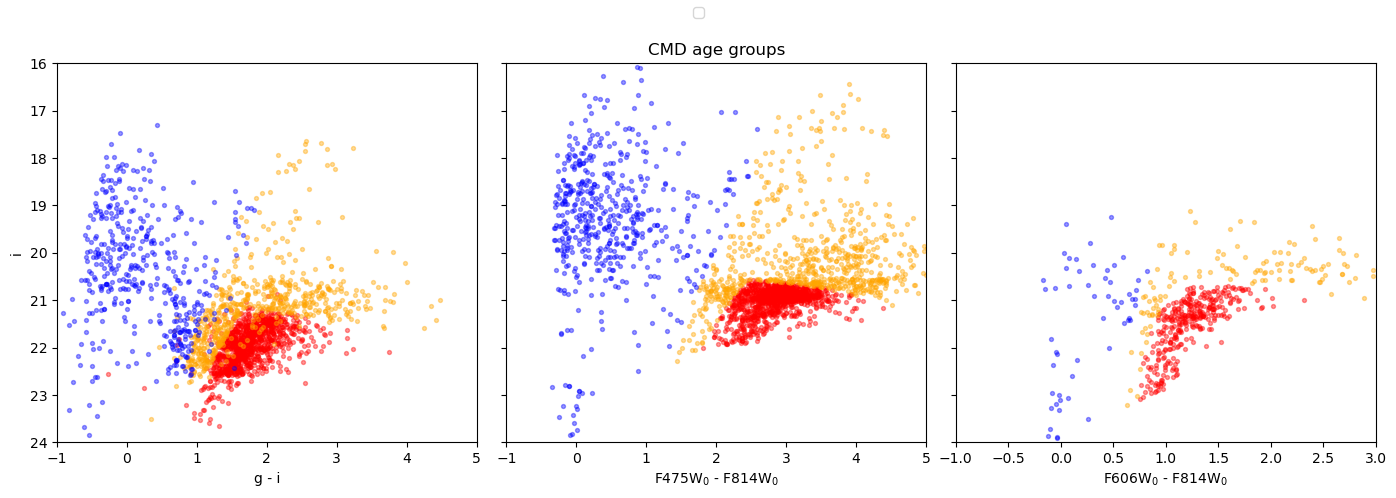

In [123]:
# Filter data by availability of magnitudes
df1 = df[(df['g'].notnull()) & (df['i'].notnull())]
df2 = df[(df['F475W0_ACS'].notnull()) & (df['F814W0_ACS'].notnull())]
df3 = df[(df['F606W0_ACS'].notnull()) & (df['F814W0_ACS'].notnull())]

# Set color and label mappings
colors = {'young': 'blue', 'int': 'orange', 'old': 'red'}
labels = {'young': 'young', 'int': 'intermediate', 'old': 'old'}

# Plot CMDs
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

# Panel 1: g - i vs i
for group in ['old', 'int', 'young']:
    subset = df1[df1['age_group'] == group]
    axes[0].scatter(subset['g'] - subset['i'], subset['i'], color=colors[group], s=8, alpha=0.4)
axes[0].invert_yaxis()
axes[0].set_xlim(-1, 5)
axes[0].set_ylim(24, 16)
axes[0].set_xlabel('g - i')
axes[0].set_ylabel('i')

# Panel 2: F475W0 - F814W0
for group in ['old', 'int', 'young']:
    subset = df2[df2['age_group'] == group]
    axes[1].scatter(subset['F475W0_ACS'] - subset['F814W0_ACS'], subset['F814W0_ACS'], color=colors[group], s=8, alpha=0.4)
axes[1].invert_yaxis()
axes[1].set_xlim(-1, 5)
axes[1].set_ylim(24, 16)
axes[1].set_xlabel('F475W$_0$ - F814W$_0$')
axes[1].set_title('CMD age groups')

# Panel 3: F606W0 - F814W0
for group in ['old', 'int', 'young']:
    subset = df3[df3['age_group'] == group]
    axes[2].scatter(subset['F606W0_ACS'] - subset['F814W0_ACS'], subset['F814W0_ACS'], color=colors[group], s=8, alpha=0.4)
axes[2].invert_yaxis()
axes[2].set_xlim(-1, 3)
axes[2].set_ylim(24, 16)
axes[2].set_xlabel('F606W$_0$ - F814W$_0$')

# Add unified legend
fig.legend(*axes[0].get_legend_handles_labels(), loc='upper center', ncol=3)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

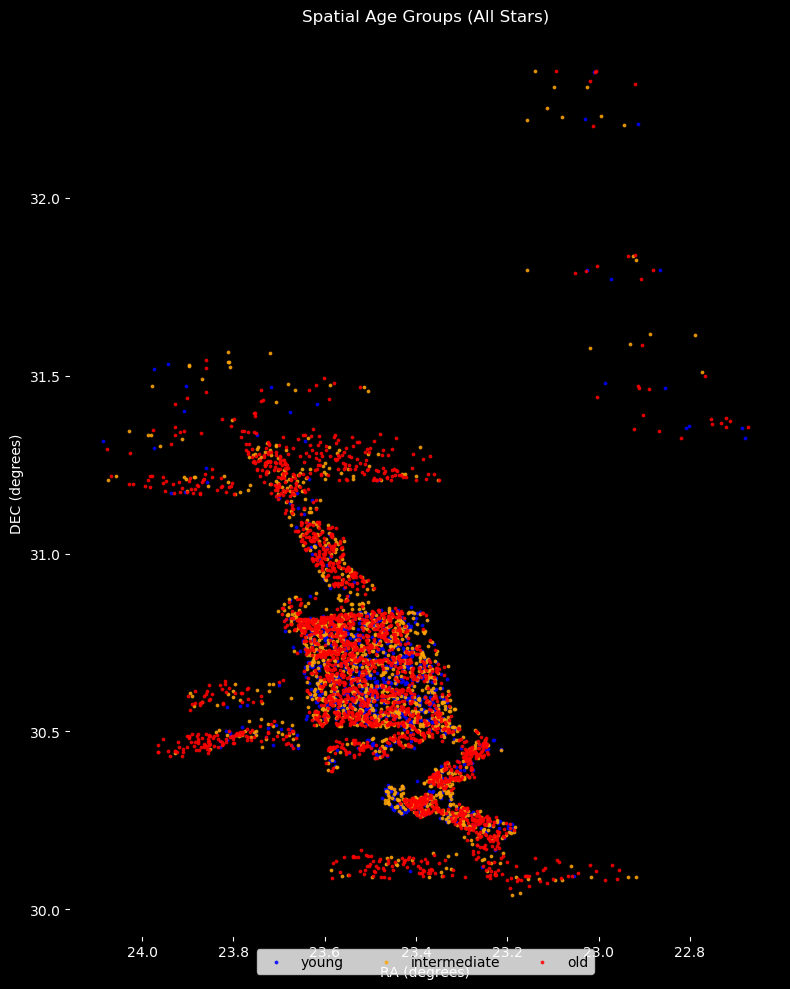

In [124]:
plt.figure(figsize=(8, 10), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')

for group in ['young', 'int', 'old']:
    subset = df[df['age_group'] == group]
    plt.scatter(subset['RA_DEG'], subset['DEC_DEG'], color=colors[group], s=3, label=labels[group], alpha=0.8)

plt.xlabel("RA (degrees)", color='white')
plt.ylabel("DEC (degrees)", color='white')
plt.tick_params(colors='white')
plt.gca().invert_xaxis()
plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))
plt.title("Spatial Age Groups (All Stars)", color='white')
plt.tight_layout()
plt.show()

In [125]:
# Filter valid coordinates
df = df[df['RA_DEG'].notnull() & df['DEC_DEG'].notnull()]

# Define M33 center
center_coord = SkyCoord(ra=23.4621 * u.deg, dec=30.6602 * u.deg)
star_coords = SkyCoord(ra=df['RA_DEG'].values * u.deg, dec=df['DEC_DEG'].values * u.deg)

# Compute angular and physical projected distance
df['r_arcmin'] = star_coords.separation(center_coord).arcminute
df['r_kpc'] = df['r_arcmin'] * (np.pi / 180 / 60) * 794  # arcmin to kpc

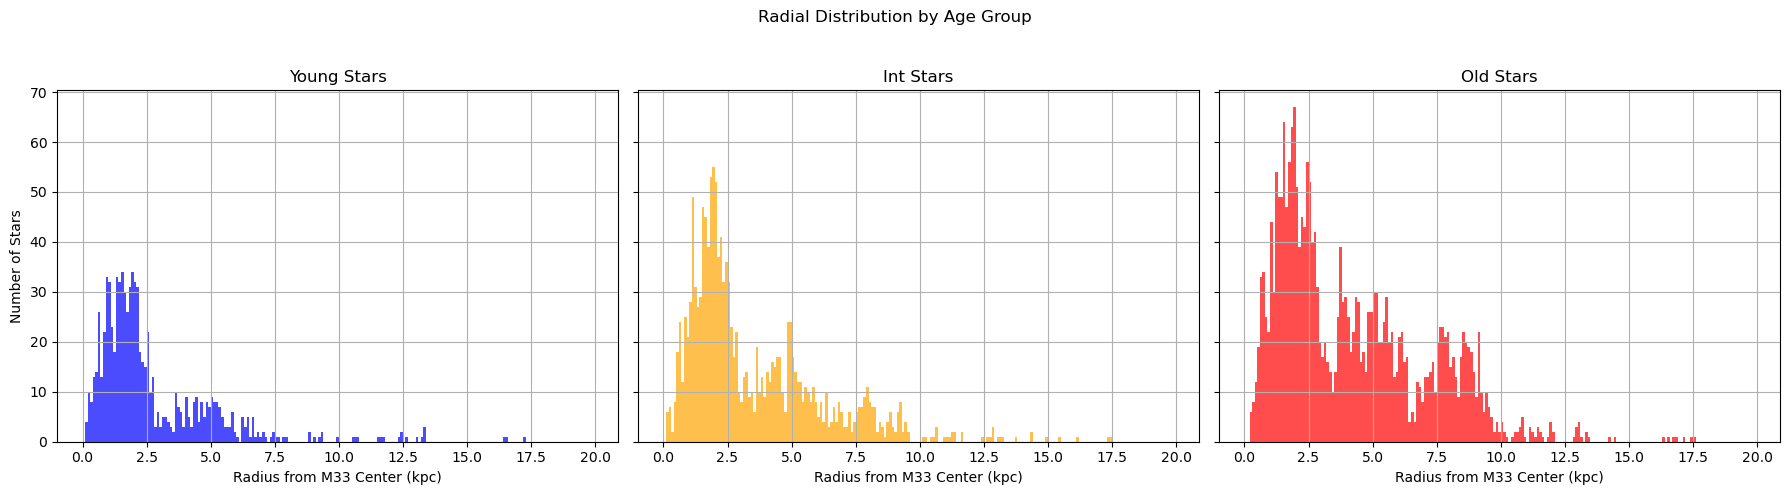

In [126]:
# === Radial histogram by age ===
# Define bins and age groups
bins = np.arange(0, 20, 0.1)
age_groups = ['young', 'int', 'old']
colors = {'young': 'blue', 'int': 'orange', 'old': 'red'}

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Plot each age group in its own subplot
for i, group in enumerate(age_groups):
    subset = df[df['age_group'] == group]
    axes[i].hist(subset['r_kpc'], bins=bins, color=colors[group], alpha=0.7, histtype='stepfilled')
    axes[i].set_title(f'{group.capitalize()} Stars')
    axes[i].set_xlabel('Radius from M33 Center (kpc)')
    if i == 0:
        axes[i].set_ylabel('Number of Stars')
    axes[i].grid(True)

# Overall title and layout
plt.suptitle('Radial Distribution by Age Group')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [127]:
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd
from tqdm import tqdm

# === Split by age group ===
young_df = df[df['age_group'] == 'young'].copy()
int_df   = df[df['age_group'] == 'int'].copy()
old_df   = df[df['age_group'] == 'old'].copy()

# === Create SkyCoord objects ===
young_coords = SkyCoord(ra=young_df['RA_DEG'].values * u.deg, dec=young_df['DEC_DEG'].values * u.deg)
int_coords   = SkyCoord(ra=int_df['RA_DEG'].values * u.deg, dec=int_df['DEC_DEG'].values * u.deg)
old_coords   = SkyCoord(ra=old_df['RA_DEG'].values * u.deg, dec=old_df['DEC_DEG'].values * u.deg)

# === Matching ===
matched_triplets = []
match_radius = 1.0 * u.arcminute

used_int = set()
used_old = set()

for i in tqdm(range(len(young_df)), desc="Matching triplets from young base"):
    young_star = young_coords[i]

    # Match to int stars
    idx_int, sep2d_int, _ = young_star.match_to_catalog_sky(int_coords)
    idx_int = int(idx_int)  # extract integer
    if sep2d_int > match_radius or idx_int in used_int:
        continue

    # Match to old stars
    idx_old, sep2d_old, _ = young_star.match_to_catalog_sky(old_coords)
    idx_old = int(idx_old)  # extract integer
    if sep2d_old > match_radius or idx_old in used_old:
        continue

    used_int.add(idx_int)
    used_old.add(idx_old)

    matched_triplets.append({
        'young_idx': young_df.index[i],
        'int_idx': int_df.iloc[idx_int].name,
        'old_idx': old_df.iloc[idx_old].name
    })

# === Output ===
triplets_df = pd.DataFrame(matched_triplets)
print(f"Matched triplets found: {len(triplets_df)}")

Matching triplets from young base: 100%|████| 832/832 [00:00<00:00, 1342.86it/s]

Matched triplets found: 437


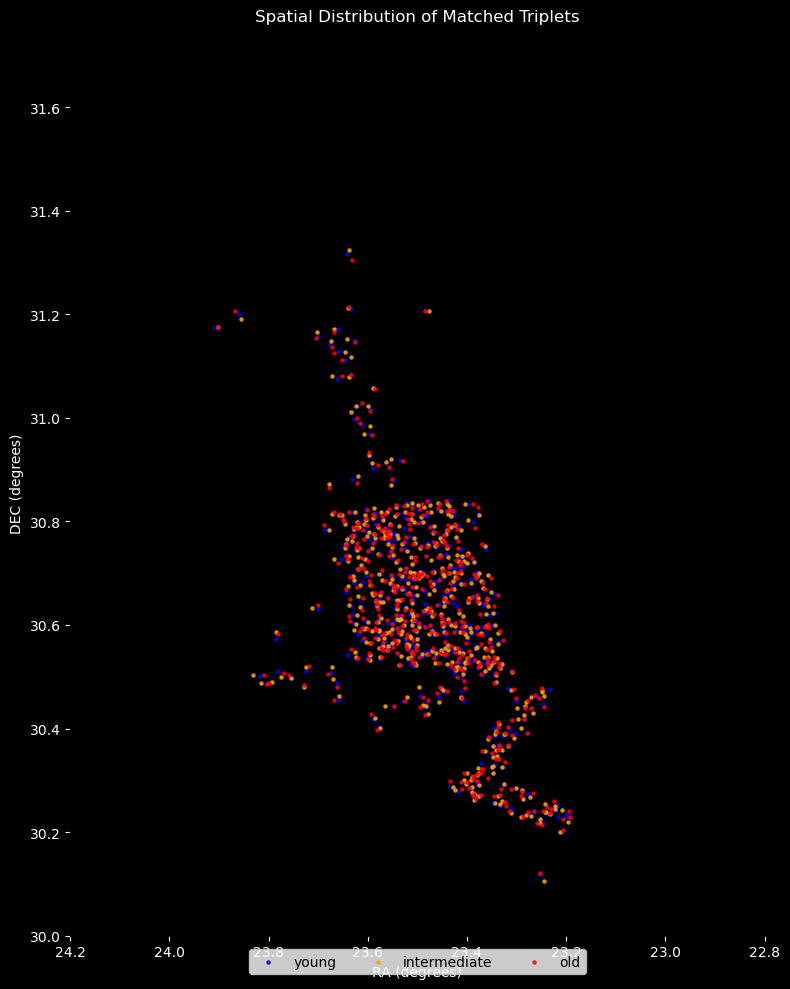

In [128]:
# Combine matched star data
triplet_full_data = pd.concat([
    df.loc[triplets_df['old_idx']].assign(group='old'),
    df.loc[triplets_df['int_idx']].assign(group='int'),
    df.loc[triplets_df['young_idx']].assign(group='young')
]).reset_index(drop=True)

# Filter to valid coordinates
triplet_full_data = triplet_full_data[triplet_full_data['RA_DEG'].notnull() & triplet_full_data['DEC_DEG'].notnull()]

# Plot triplet positions
plt.figure(figsize=(8, 10), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')

for group in ['young', 'int', 'old']:
    subset = triplet_full_data[triplet_full_data['group'] == group]
    plt.scatter(subset['RA_DEG'], subset['DEC_DEG'], color=colors[group], s=5, label=labels[group], alpha=0.8)

plt.xlabel("RA (degrees)", color='white')
plt.ylabel("DEC (degrees)", color='white')
plt.xlim(22.8, 24.2)
plt.ylim(30, 31.75)
plt.tick_params(colors='white')
plt.gca().invert_xaxis()
plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))
plt.title("Spatial Distribution of Matched Triplets", color='white')
plt.tight_layout()
plt.show()